In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the data

In [2]:
file_path = "datasets/imdb/imdb_cleaned.csv"
df = pd.read_csv(file_path)
df.head()

,movie_id,description,genre,description_length,clean_description,summary
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance,2103,elle evans joey king finally complete high sch...,"It's the next day and Elle, Lee, Noah, and Rac..."
1,tt1798632,A young girl tries to understand how she myste...,horror,290,young girl try understand mysteriously gain po...,After being experimented on by a secret govern...
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy,481,1800s england well mean selfish young woman me...,Emma starts making a match for Harriet and Mr ...
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance,736,abby holland kristen stewart harper caldwell m...,Abby dislikes Christmas since her parents pass...
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance,234,olga mak year apart successful woman establish...,Olga and Maks are 15 years apart. She is a suc...


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Input / Target
X = df['summary']
y = df['genre']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Label encoding for both models
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


## Logistic Regression Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train_enc)

# Predict
lr_preds = lr_model.predict(X_test_tfidf)

# Evaluate
print("Logistic Regression Report:")
print(classification_report(y_test_enc, lr_preds, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test_enc, lr_preds))


Logistic Regression Report:
              precision    recall  f1-score   support

      action       0.81      0.78      0.80        50
      comedy       0.56      0.58      0.57        50
      horror       0.69      0.70      0.69        50
     romance       0.65      0.64      0.65        50

    accuracy                           0.68       200
   macro avg       0.68      0.67      0.68       200
weighted avg       0.68      0.68      0.68       200

Accuracy: 0.675


## LSTM model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=300)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=300)

# One-hot encoding of labels
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Build model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=300),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_seq, y_train_cat, epochs=20, batch_size=64, validation_split=0.1)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.2556 - loss: 1.3874 - val_accuracy: 0.3000 - val_loss: 1.3826
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3466 - loss: 1.3800 - val_accuracy: 0.2750 - val_loss: 1.3798
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4249 - loss: 1.3693 - val_accuracy: 0.3750 - val_loss: 1.3716
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5548 - loss: 1.3293 - val_accuracy: 0.4875 - val_loss: 1.3365
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6377 - loss: 1.2004 - val_accuracy: 0.4125 - val_loss: 1.3090
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6717 - loss: 0.8680 - val_accuracy: 0.4500 - val_loss: 1.2947
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8250 - loss: 0.6091 - val_accuracy: 0.5625 - val_loss: 1.2077
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9007 - loss: 0.3484 - val_accuracy: 0.450

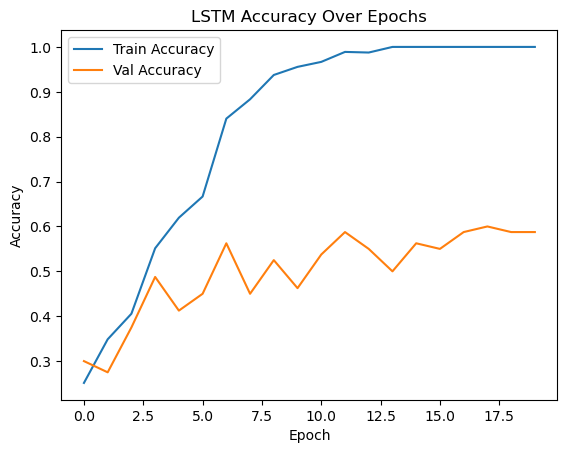

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy Over Epochs")
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import classification_report

# LSTM predictions
lstm_preds = model.predict(X_test_seq).argmax(axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
print("LSTM Accuracy:", accuracy_score(y_test_enc, lstm_preds))
print("LSTM Classification Report:")
print(classification_report(y_test_enc, lstm_preds, target_names=le.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
LSTM Accuracy: 0.48
LSTM Classification Report:
              precision    recall  f1-score   support

      action       0.68      0.42      0.52        50
      comedy       0.30      0.66      0.42        50
      horror       0.71      0.34      0.46        50
     romance       0.69      0.50      0.58        50

    accuracy                           0.48       200
   macro avg       0.60      0.48      0.49       200
weighted avg       0.60      0.48      0.49       200



In [19]:
model.save("imdb_lstm_model.h5")

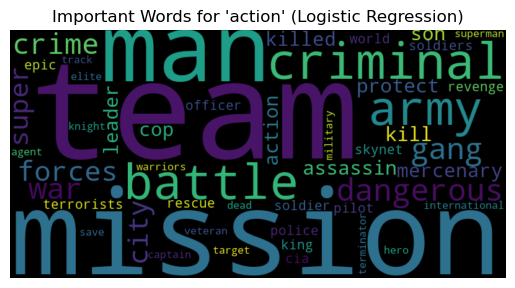

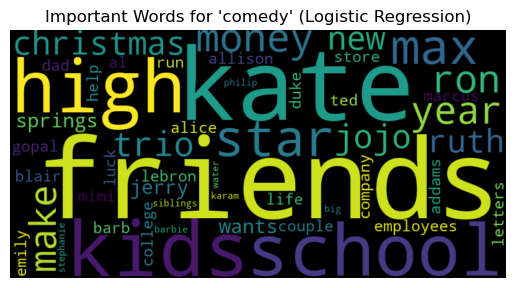

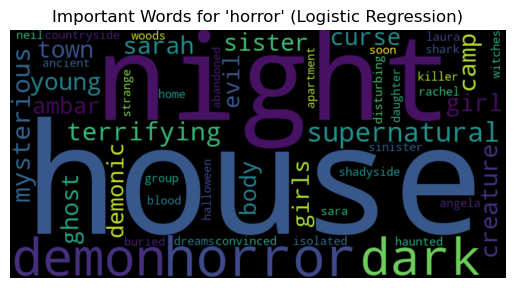

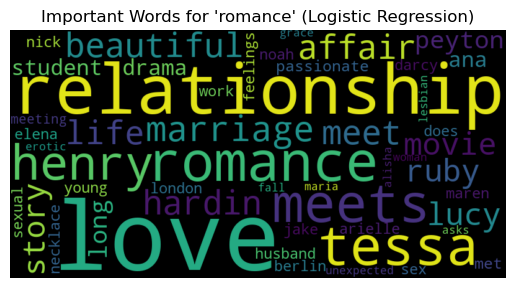

In [10]:
from wordcloud import WordCloud

def get_top_words(model, class_label, top_n=50):
    class_idx = list(le.classes_).index(class_label)
    coefs = model.coef_[class_idx]
    feature_names = vectorizer.get_feature_names_out()
    top_words = {feature_names[i]: coefs[i] for i in coefs.argsort()[-top_n:]}
    return top_words

for genre in le.classes_:
    top_words = get_top_words(lr_model, genre)
    wc = WordCloud(width=800, height=400).generate_from_frequencies(top_words)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Important Words for '{genre}' (Logistic Regression)")
    plt.show()


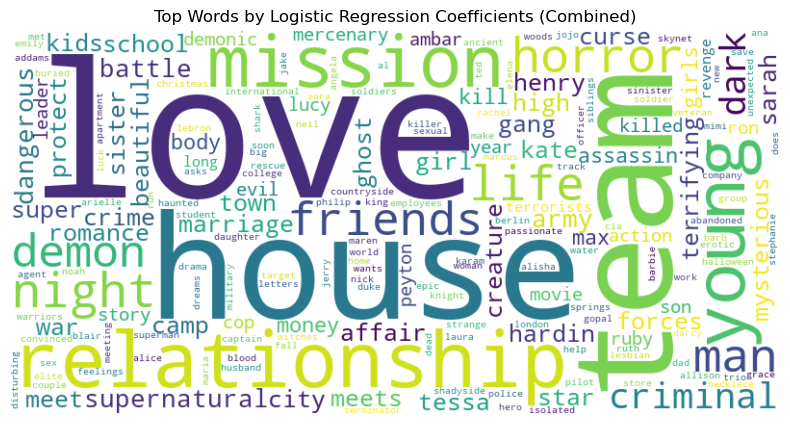

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def get_all_top_words(model, vectorizer, label_encoder, top_n=50):
    combined_words = {}
    feature_names = vectorizer.get_feature_names_out()
    
    for class_idx, genre in enumerate(label_encoder.classes_):
        coefs = model.coef_[class_idx]
        top_indices = np.argsort(coefs)[-top_n:]
        for i in top_indices:
            word = feature_names[i]
            weight = coefs[i]
            if word in combined_words:
                combined_words[word] += weight  # 累加每类对词的“支持度”
            else:
                combined_words[word] = weight
    return combined_words


combined_top_words = get_all_top_words(lr_model, vectorizer, le, top_n=50)

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(combined_top_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words by Logistic Regression Coefficients (Combined)")
plt.show()


Top 20 important words by mean embedding value (LSTM):
        feature  coefficient
1438     string     0.014162
478       marry     0.013775
889        wolf     0.013071
4630     landor     0.012981
1640      willy     0.012976
1175   receives     0.012808
4649      famed     0.012712
3733    priests     0.012502
1799       lack     0.012261
3378  impending     0.012093
4578   veronica     0.011768
2790     soviet     0.011742
429     outside     0.011733
1751      hides     0.011697
2448       neck     0.011684
3786     airbnb     0.011676
1475    passing     0.011636
526        seen     0.011611
852    building     0.011583
637   halloween     0.011535


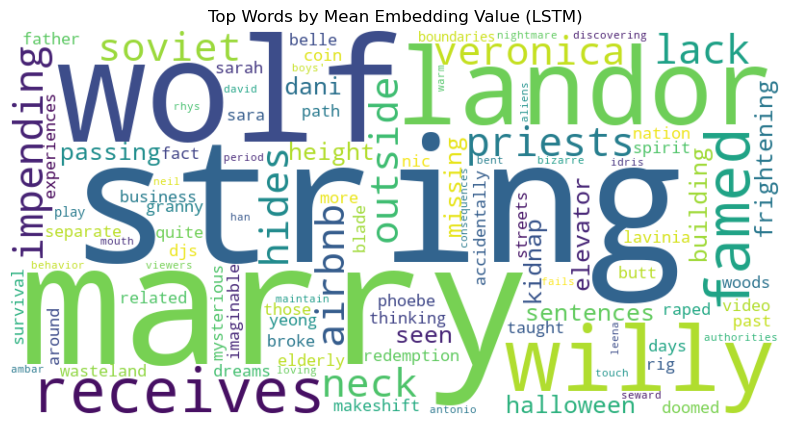

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Embedding
from wordcloud import WordCloud
import matplotlib.pyplot as plt


embedding_layer = [layer for layer in model.layers if isinstance(layer, Embedding)][0]
embedding_weights = embedding_layer.get_weights()[0]  # shape: (vocab_size, embedding_dim)


word_index = tokenizer.word_index
index_to_word = {index: word for word, index in word_index.items()}


word_scores = []
words = []

for word, idx in word_index.items():
    if idx < embedding_weights.shape[0]:  
        weight_vector = embedding_weights[idx]
        score = np.mean(weight_vector)  
        word_scores.append(score)
        words.append(word)


df_lstm_mean = pd.DataFrame({'feature': words, 'coefficient': word_scores})
df_lstm_mean = df_lstm_mean.sort_values(by='coefficient', ascending=False)


print("Top 20 important words by mean embedding value (LSTM):")
print(df_lstm_mean.head(20))


top_words = dict(zip(df_lstm_mean['feature'].head(100), df_lstm_mean['coefficient'].head(100)))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words by Mean Embedding Value (LSTM)")
plt.show()


In [18]:
disagreement_df = df.loc[X_test.index].copy()
disagreement_df['True'] = le.inverse_transform(y_test_enc)
disagreement_df['LR'] = le.inverse_transform(lr_preds)
disagreement_df['LSTM'] = le.inverse_transform(lstm_preds)


disagreements = disagreement_df[
    (disagreement_df['LR'] != disagreement_df['True']) |
    (disagreement_df['LSTM'] != disagreement_df['True'])
]


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

display(disagreements[['summary', 'True', 'LR', 'LSTM']].head(10))




,summary,True,LR,LSTM
118,"When police raid a house in El Paso, they find it full of dead Latinos, and only one survivor. Known as ""The Traveler,"" he is taken to the police station for questioning. There, he recounts tales of horrors from his life, chronicling portals leading to other worlds, mythical beings, demons and the undead; he speaks of legends from Latin America. Satanic Hispanics tells stories by top Latin filmmakers that showcase the skills of Hispanic talent, both on and off screen.",horror,horror,comedy
358,"In the next installment, the survivors of the Ghostface killings leave Woodsboro behind and start a fresh chapter in New York City. Following the latest Ghostface killings, the four survivors leave Woodsboro behind and start a fresh chapter. In Scream VI, Melissa Barrera ""Sam Carpenter"", Jasmin Savoy Brown ""Mindy MeeksMartin"", Mason Gooding ""Chad MeeksMartin"", Jenna Ortega ""Tara Carpenter"", Hayden Panettiere ""Kirby Reed"" and Courteney Cox ""Gale Weathers"" return to their roles in the franchise alongside Jack Champion, Henry Czerny, Liana Liberato, Dermot Mulroney, Devyn Nekoda, Tony Revolori, Josh Segarra, and Samara Weaving.Paramount', 'One year after the Woodsboro killings orchestrated by Richie Kirsch and Amber Freeman, Blackmore University professor Laura Crane Samara Weaving is murdered by her student Jason Carvey Tony Revolori wearing a Ghostface costume. Jason plots with his roommate Greg to kill sisters Sam Melissa Barrera and Tara Carpenter Jenna Ortega to finish the ""movie"" that Richie and Amber wanted to make. However, Jason receives a call from a different Ghostface, who has killed Greg and subsequently stabs Jason to death.Sam and Tara now live in New York City, with Tara attending Blackmore University alongside fellow survivors Chad Mason Gooding and Mindy MeeksMartin Jasmin Savoy Brown, their roommate Quinn Bailey Liana Liberato, Mindy's girlfriend Anika Kayoko Devyn Nekoda, and Chad's roommate Ethan Landry Jack Champion.",horror,horror,comedy
0,"It's the next day and Elle, Lee, Noah, and Rachel head down to the beach house to help the Flynns to sell it. Her father agrees and Elle, Lee, Rachel, and Noah get settled in the beach house. Elle and Noah go out for a walk on the beach at night and Noah tells Elle that Chloe was going to be around and invited her to stay at the beach house. Chloe and Noah are on the beach talking about Elle. The next day, Chloe and Elle talk about Noah and Elle's relationship while Rachel overhears them.",romance,horror,horror
478,"Joe is a middle-school band teacher whose life hasn't quite gone the way he expected. Joe Gardner is a middle school teacher with a love for jazz music. Joe Gardner is a middle school music teacher. Where he helps his mentor realise their true passion and spark.ÃƒÂ‚Ã‚Â—christopheyao'Joe is a middle school music teacher in New York. He then finds himself in a limbo-world somewhere between life and death.ÃƒÂ‚Ã‚Â—grantss .Joe Gardner, a middle school music teacher, feels stuck in life and unfulfilled at his job.",comedy,comedy,romance
379,"The Grinch tells the story of a cynical grump who goes on a mission to steal Christmas, only to have his heart changed by a young girl's generous holiday spirit. When the Whos declare they are going to make Christmas three times bigger this year, the Grinch realizes there is only one way for him to gain some peace and quiet: he must steal Christmas. To do so, he decides to pose as Santa Claus on Christmas Eve, even going so far as to trap a lackadaisical misfit reindeer to pull his sleigh. Meanwhile, down in Whoville, Cindy-Lou Who (Cameron Seely), a young girl overflowing with holiday cheer, plots with her gang of friends to trap Santa Claus as he makes his Christmas Eve rounds so that she can thank him for help for her overworked single mother. Will the Grinch succeed in silencing the Whos' holiday cheer once and for all?",comedy,comedy,action
555,"A city doctor is forced to work in the remot

Sample 118
True Genre: Horror

LR Prediction: Horro

LSTM Prediction: Comedy

Explanation:
The summary contains clear horror cues: “dead Latinos,” “demons,” “undead,” and “horrors from his life.” Logistic Regression likely picked up on these strong keyword signals, which are heavily weighted in TF-IDF.
LSTM, on the other hand, may have been confused by the latter part of the summary, which discusses Hispanic filmmakers and showcasing talent. These sentences carry a more neutral or even positive tone. Because LSTM considers word sequences and contextual flow, it might have downplayed the horror signals in favor of the artistic tone, misclassifying it as a comedy.

Sample 358
True Genre: Horror

LR Prediction: Horror 

LSTM Prediction: Comedy 

Explanation:
This is a classic horror sequel setup involving the Ghostface killer, with keywords like “murdered,” “stabbed,” “killings,” and “costume.” LR likely got it right by leveraging the high TF-IDF weights for these violent terms.
LSTM struggled likely due to the overwhelming number of character names and details unrelated to genre. The actual horror events may have been “buried” inside a long block of neutral or even friendly descriptions, making the LSTM treat it more like an ensemble cast narrative typical in comedies.

Sample 0
True Genre: Romance

LR Prediction: Horror 

LSTM Prediction: Horror 

Explanation:
This is a romance-driven plot involving beach trips, emotional talks, and character interactions. However, the summary lacks strong romance keywords such as “love,” “relationship,” “date,” or “kiss.”
Both LR and LSTM fail here but for different reasons:

LR possibly misclassified due to words like “overhears,” “invited,” and “stay,” which might appear in thriller contexts as well.

LSTM, without strong emotional progression or romantic narrative structure, may have defaulted to a more suspenseful interpretation due to its sequential modeling.
In short, the romantic intent is subtle and not well-represented in keywords or structure.